# Split and plot data

In [1]:
import numpy as np
import random
import time
import pandas as pd
import progressbar as pb
import argparse
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.core.indexes.range import RangeIndex

def load_data(file_path: str) -> object:
    '''Load NPY file'''
    file = open(file_path, 'rb')
    data = np.load(file, allow_pickle=False)
    file.close()
    return data

def load_posistions(root_dir: Path) -> pd.DataFrame:
    # Load user possitions
    positions_file = root_dir.joinpath('user_positions.npy')
    positions = load_data(positions_file)
    
    # Set up dataframe
    df = pd.DataFrame(data=positions, columns=['x', 'y', 'z'])
    
    return df

## Define function to choose the training and testing indices:
1. Split x into 10 columns (x_bins) and y into 10 rows (y_bins)
2. Group positions in the dataframe according to their respective x and y bins
3. Divide data into sectors using the bins and save their respective indices
4. Iterate trough sectors selecting 80% of the indices for training and the rest for testing

In [2]:
def separate_indices(dataframe: pd.DataFrame, grid_size: int, training_percentage=0.8) -> tuple:
    '''Separe dataset into training set and test set'''
    
    df = dataframe.copy()
    x_array = np.array(df.x)
    y_array = np.array(df.y)

    # Split dataframe into 10 columns (x_bins) and 10 rows (y_bins) (for grid_size = 10)
    x_bins = pd.cut(df.x, np.linspace(min(x_array) - 1, max(x_array) + 1, num=grid_size))
    y_bins = pd.cut(df.y, np.linspace(min(y_array) - 1, max(y_array) + 1, num=grid_size))
    
    # Add column to keep track of indices
    df['i'] = RangeIndex(len(df))
    
    # Group data by bins and set them as index
    df.groupby([x_bins, y_bins])
    df['x_bin'] = x_bins
    df['y_bin'] = y_bins
    df = df.set_index(['x_bin', 'y_bin'])

    # Divide indices into their respective sectors using the bins
    sectors = []
    print('Selecting training set indices')
    for x_bin in pb.progressbar(x_bins.drop_duplicates()):
        for y_bin in y_bins.drop_duplicates():
            df_filtered = df.loc[[(x_bin, y_bin)]]
            sector = df_filtered['i'].tolist()
            sectors.append(sector)

    # Separate training set and test set indices for each sector
    training_set = []
    test_set = []
    random.seed(time.time())
    for sec in sectors:
        training_indices = random.sample(sec, int(len(sec) * training_percentage))
        test_indices = list(set(sec) - set(training_indices))
        training_set += training_indices
        test_set += test_indices

    return training_set, test_set

N/A% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Selecting training set indices


100% (9 of 9) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


201568 50436 252004
201568 50436 252004


<AxesSubplot:xlabel='x', ylabel='y'>

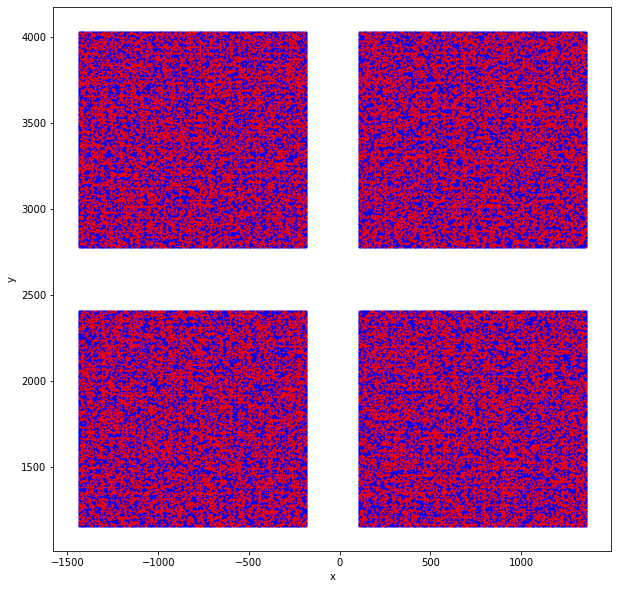

In [3]:
dataset_root_dir = Path('/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS')
grid_size = 10

df = load_posistions(dataset_root_dir)
train_indices, test_indices = separate_indices(df, grid_size)
print(len(train_indices), len(test_indices), len(train_indices) + len(test_indices))

train_df, test_df = df.loc[train_indices], df.loc[test_indices]
print(len(train_df), len(test_df), len(train_df) + len(test_df))

ms = 1
figsize = (10,10)
ax = train_df.plot.scatter(x='x', y='y', color='blue', s=ms)
test_df.plot.scatter(x='x', y='y', color='red', s=ms, ax=ax, figsize=figsize)

In [4]:
# samples_dir = dataset_root_dir.joinpath('samples')
train_filepath = dataset_root_dir.joinpath('train_indices.npy')
test_filepath = dataset_root_dir.joinpath('test_indices.npy')
np.save(train_filepath, np.array(train_indices))
np.save(test_filepath, np.array(test_indices))